In [22]:
#importing libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
#display Image
def displayImg(img):
    plt.figure(figsize=(10.24,10.24))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()

In [62]:
#Initialization
f=50#focal length
x_resolution=1024
y_resolution=1024
FOVx=FOVy=50
sigma=1.5#defocus level
#need to add more

# Mathmatical Modeling

1. Calc. of Rotational Mat. M

In [63]:
def getRotationalMat(alpha_0,delta_0,phi_0):
    """Gets the ascension, declination and role angle as inputs and return a rotational matrix"""
    a1=(np.sin(alpha_0)*np.cos(phi_0))-(np.cos(alpha_0)*np.sin(delta_0)*np.sin(phi_0))
    a2=(-np.sin(alpha_0)*np.sin(phi_0))-(np.cos(alpha_0)*np.sin(delta_0)*np.cos(phi_0))
    a3=-np.cos(alpha_0)*np.cos(delta_0)
    b1=(-np.cos(alpha_0)*np.cos(phi_0))-(np.sin(alpha_0)*np.sin(delta_0)*np.sin(phi_0))
    b2=(np.cos(alpha_0)*np.sin(phi_0))-(np.sin(alpha_0)*np.sin(delta_0)*np.cos(phi_0))
    b3=-np.sin(alpha_0)*np.cos(delta_0)
    c1=np.cos(alpha_0)*np.sin(phi_0)
    c2=np.cos(alpha_0)*np.cos(phi_0)
    c3=-np.sin(delta_0)
    M=np.array([
        [a1,a2,a3],
        [b1,b2,b3],
        [c1,c2,c3]
    ],dtype="float64")
    return M.transpose()

In [64]:
def obtainStarSensorCoordinateSystem(M_T,alpha_i,delta_i):
    """
    M_T=Transpose of orthogonal matrix. ie. Rotational Matrix
    alpha_i=ith ascension
    delta_i=ith declination
    """
    direction_vector_of_stars_in_celestial_coord_sys=np.array([
        [np.cos(alpha_i)*np.cos(delta_i)],
        [np.sin(alpha_i)*np.cos(delta_i)],
        [np.sin(delta_i)]
    ],dtype="float64")
    return np.matmul(M_T,direction_vector_of_stars_in_celestial_coord_sys)

# Condition stars ascension and declination in the cameras FOV frame

In [65]:
def checkStarsAlphaDeltaWithInFOV(alpha_i,delta_i,alpha_0,delta_0,FOVx,FOVy):
    """
    Takes stars position, camera position and FOV as input and checks whether
    stars position is within camera FOV frame
    If returns True, stars position is within FOV
    """
    R=np.sqrt((FOVx**2)+(FOVy**2))/2
    rangeOfAlpha=np.array([alpha_0-(R/np.cos(delta_0)),alpha_0+(R/np.cos(delta_0))])
    rangeOfDelta=np.array([delta_0-R,delta_0+R])
    return np.logical_and(rangeOfAlpha[0]<alpha_i<rangeOfAlpha[1],rangeOfDelta[0]<delta_i<rangeOfDelta[1])
    

# Projection

In [66]:
def getPixelXY(f,res_x,res_y,sensor_coord_mat):
    proj_mat=np.array([
        [f,0,res_x/2],
        [0,f,res_y/2],
        [0,0,1]
    ])
    return np.matmul(proj_mat,sensor_coord_mat)

In [67]:
ra=44
dec=22

In [68]:
M_T=getRotationalMat(0,0,0)
M_T

array([[ 0., -1.,  0.],
       [-0.,  0.,  1.],
       [-1., -0., -0.]])

In [69]:
sensor_coord=obtainStarSensorCoordinateSystem(M_T,ra,dec)
sensor_coord

array([[ 0.01770123],
       [-0.00885131],
       [ 0.99980414]])

In [70]:
#check star in FOV
print(checkStarsAlphaDeltaWithInFOV(ra,dec,0,0,FOVx=FOVx,FOVy=FOVy))

False


In [71]:
pixel_xy=getPixelXY(f,x_resolution,y_resolution,sensor_coord)
pixel_xy

array([[512.78478187],
       [511.45715482],
       [  0.99980414]])

# The composition of the Digital Star Image
A Point Spreading Function(PSF) is used to simulate the spreading of the light upon multiple pizels

In [13]:
def psfGaussianDistribution(x,y,Mv):
    k1=1000
    k2=k3=1
    H=k1*np.exp(-k2*Mv+k3)
    num=np.exp(-((x**2)+(y**2))/(2*(sigma**2)),dtype="float128")
    den=2*3.14*(sigma**2)
    return H*num/den

/home/dev/Desktop/MAJOR/Startracker-Simulator-for-Attitude-Determination-of-Spacecrafts/env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


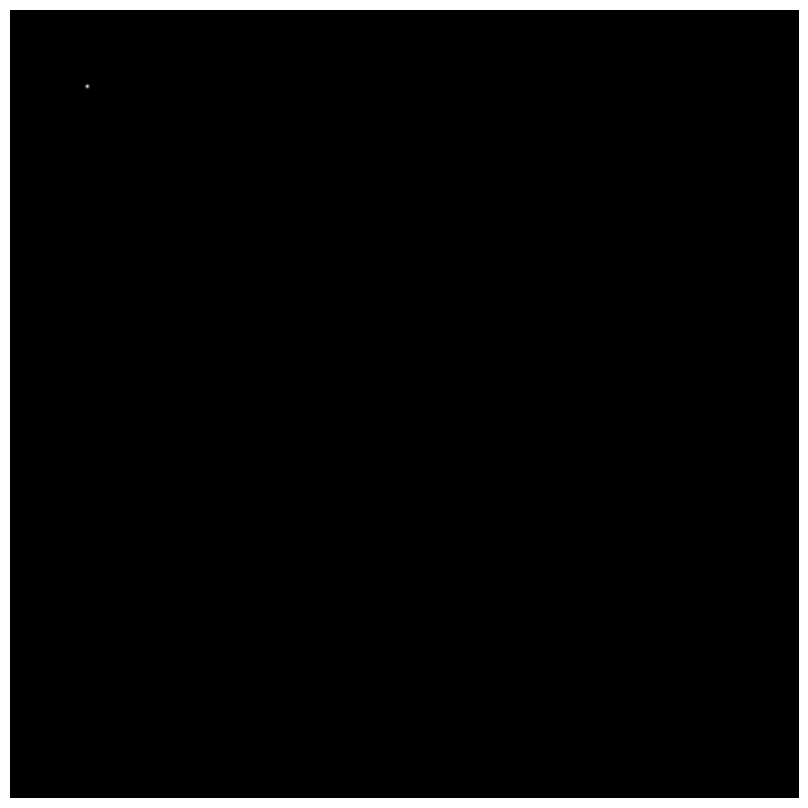

In [14]:
x = np.linspace(0,x_resolution,x_resolution)
y = np.linspace(0,y_resolution,y_resolution)
X, Y = np.meshgrid(x, y)
psf=psfGaussianDistribution(X-100,Y-100,1.5)
displayImg(psf)

[[2.05371753e-243 1.31394532e-238 7.52080876e-234 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.90727475e-243 3.77940778e-238 2.16327139e-233 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.52014250e-242 9.72570034e-238 5.56683229e-233 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]
[[2.05371753e-243 1.31394532e-238 7.52080876e-234 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [5.90727475e-243 3.77940778e-238 2.16327139e-233 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [1.52014250e-242 9.72570034e-238 5.56683229e-233 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000

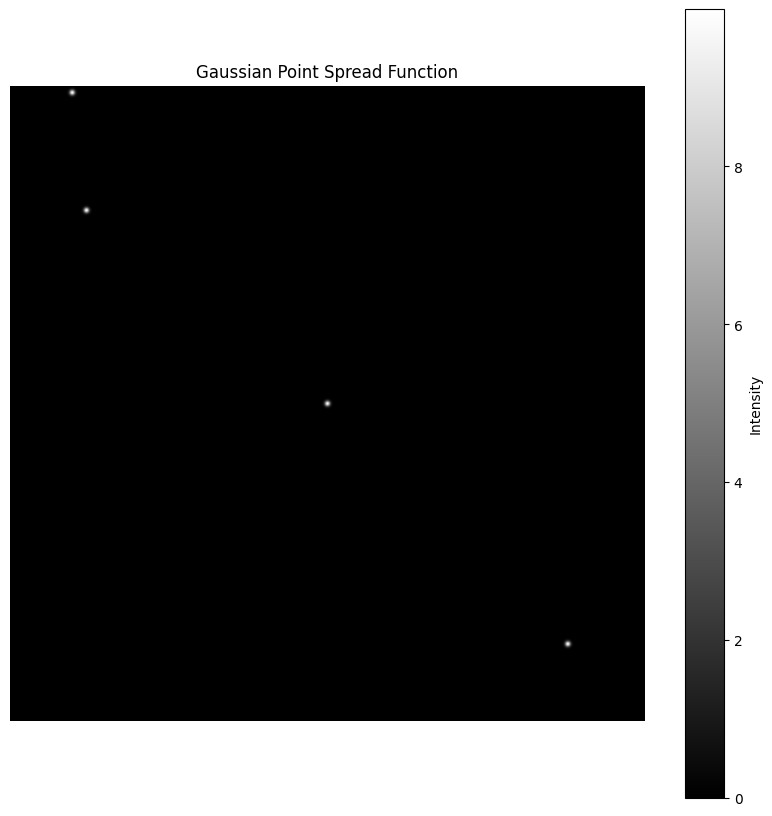

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = 10.0
sigma = 3
X_points=np.array([100,512,123,900])
Y_points=np.array([10,512,200,900])
# Calculate Gaussian PSF
def gaussian_psf(x, y):
    r_squared = x**2 + y**2
    return A * np.exp(-r_squared / (2 * sigma**2))

# Create grid of coordinates
x = np.linspace(0,1024,1024)
y = np.linspace(0,1024,1024)
X, Y = np.meshgrid(x, y)

# Calculate PSF values
PSF=np.zeros_like(Y)
for i in range(4):
    PSF += gaussian_psf(X - X_points[i], Y - Y_points[i])
    print(PSF)

print(PSF.shape)
# Display PSF as an image
plt.figure(figsize=(10.24,10.24))
plt.imshow(PSF,cmap="gray")
plt.colorbar(label='Intensity')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('off')
plt.title('Gaussian Point Spread Function')
plt.show()
plt.imsave("plot.png",PSF,cmap="gray")


In [16]:
x = np.linspace(0, 5, 5)
y = np.linspace(0, 5,5)
X, Y = np.meshgrid(x, y)
X==Y

array([[ True, False, False, False, False],
       [False,  True, False, False, False],
       [False, False,  True, False, False],
       [False, False, False,  True, False],
       [False, False, False, False,  True]])

In [17]:
X

array([[0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ]])

In [18]:
Y

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.25, 1.25, 1.25, 1.25, 1.25],
       [2.5 , 2.5 , 2.5 , 2.5 , 2.5 ],
       [3.75, 3.75, 3.75, 3.75, 3.75],
       [5.  , 5.  , 5.  , 5.  , 5.  ]])

In [19]:
psf=psfGaussianDistribution(X-2,Y-2,10)

In [20]:
psf

array([[0.0014    , 0.0016946 , 0.00172427, 0.00147485, 0.00106045],
       [0.0016946 , 0.00205118, 0.0020871 , 0.00178519, 0.0012836 ],
       [0.00172427, 0.0020871 , 0.00212365, 0.00181646, 0.00130608],
       [0.00147485, 0.00178519, 0.00181646, 0.0015537 , 0.00111715],
       [0.00106045, 0.0012836 , 0.00130608, 0.00111715, 0.00080325]],
      dtype=float128)

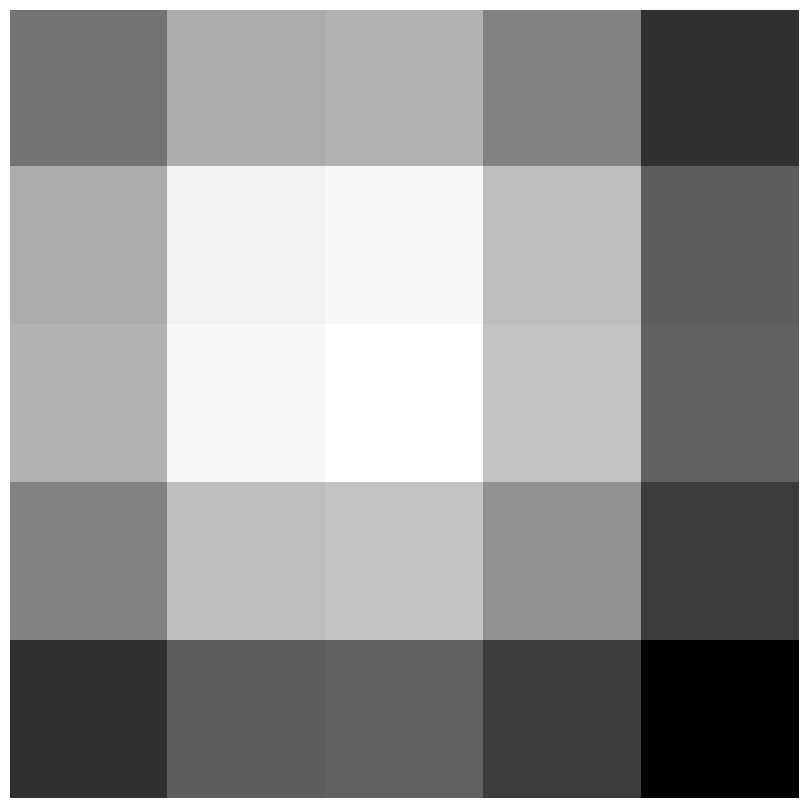

In [21]:
displayImg(psf)